# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the New York GraduationRate 2022 Data

## 1. Importing your libraries and data

In [106]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [107]:
# Define path

path = r'/Users/maitran/Documents/Grad Rate NY 2022'

In [120]:
# Import clean data
df= pd.read_excel(os.path.join(path, '02 Data', 'Prepared Data', 'Grad Rate NY 2011-2022.xlsx'), index_col = 0)

In [121]:
df.shape

(1, 12)

In [148]:
df.head(5)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Year,,,,,,,,,,,,
Grad Rate,77,77,77,78,79,80,82,82,83,84,86.1,87


In [123]:
# Transpose the DataFrame
df_1 = df.T

In [147]:
df_1.head(5)

Year,Grad Rate
2011,77.0
2012,77.0
2013,77.0
2014,78.0
2015,79.0


In [125]:
df_1.columns

Index(['Grad Rate'], dtype='object', name='Year')

In [126]:
type(df_1)

pandas.core.frame.DataFrame

## 2. Wrangling, and cleaning time-series data

In [127]:
# Check for missing values 

df_1.isnull().sum() 

Year
Grad Rate    0
dtype: int64

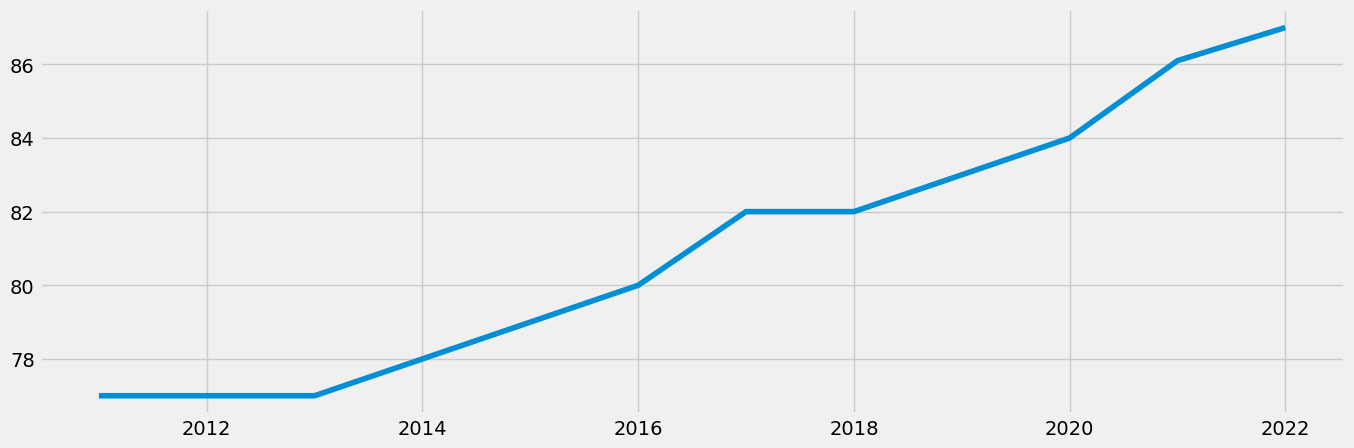

In [128]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_1)

## 3. Time-series analysis: decomposition

In [135]:
# Set the frequency of the index to 'Y' (yearly)
df_1.index.freq = 'Y'

In [146]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_1['Grad Rate'], model='additive', period=1)

In [141]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

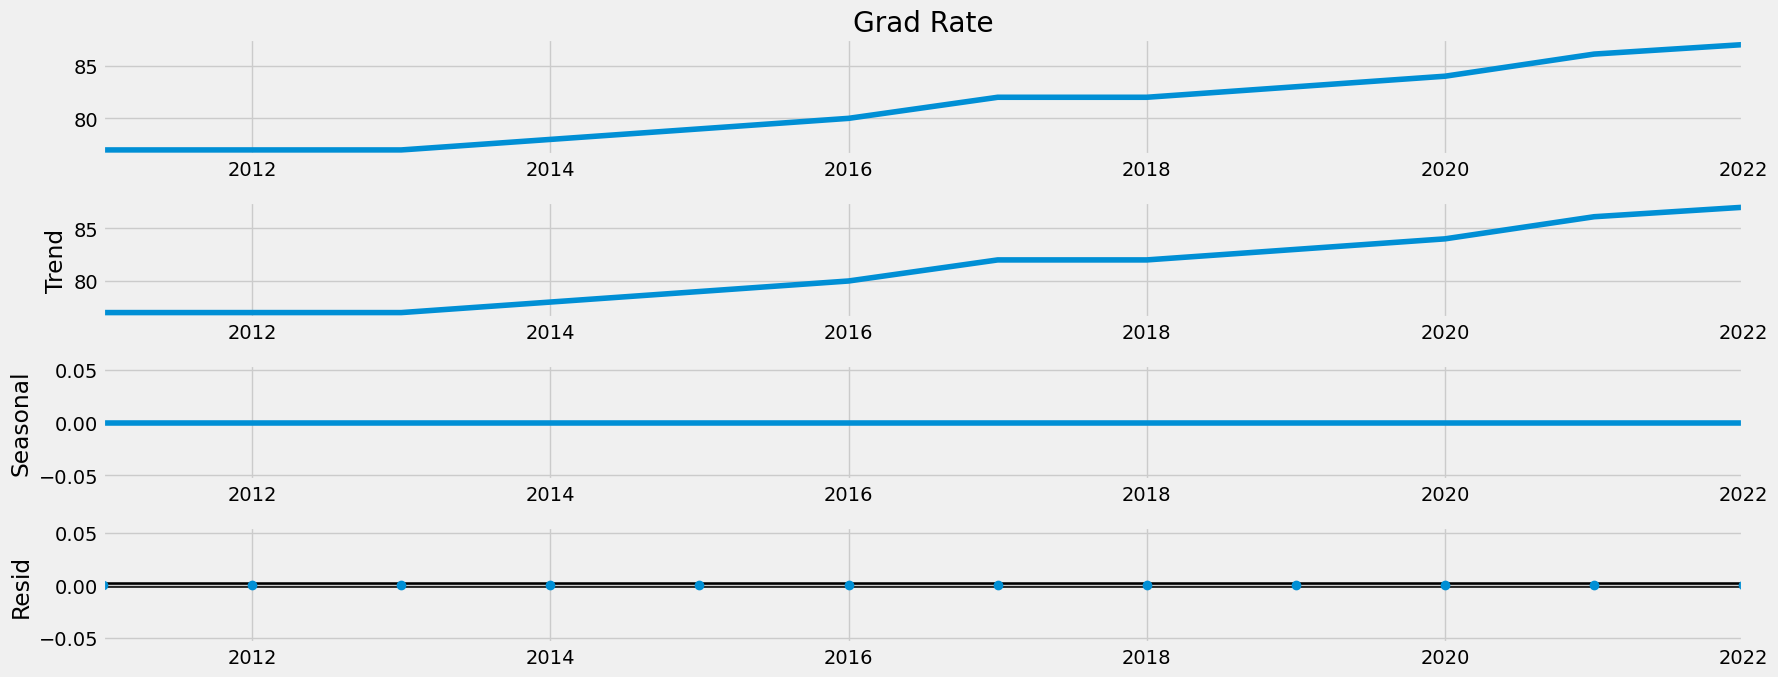

In [142]:
# Plot the separate components

decomposition.plot()
plt.show()

Observations: 
The trend in the chart above gradually increases in a linear fashion after 2013. This is a dominant trend. 

Because we didn’t have any seasonality in this data set, the curve is flat.

There isn’t much unexplained noise (which we already knew as we didn’t need to smooth the data.)

## 4. Testing for stationarity

The null hypothesis in this case would be the presence of a unit root (we want to disprove that there’s a unit root, which would mean that our data is stationary). 

The alternative hypothesis is that there’s no unit root. (If we can’t rule out the null hypothesis, our data is non-stationary.)

In [152]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_1['Grad Rate'])

Dickey-Fuller Stationarity test:
Test Statistic                  1.175109
p-value                         0.995809
Number of Lags Used             0.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


Observations: 

The p-value indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05, we have 0.99 ==> The null hypothesis is not disproved.

In order to determine the results of a statistical hypothesis test, we need to compare the test statistic to the critical value of the corresponding significance level. The test statistic (1.17) is larger than the critical value at both the five and ten percent significance levels (-3.2, -2.7), we can’t reject the null hypothesis.

==> The data is non-stationary. This means that there is a unit root in the data.

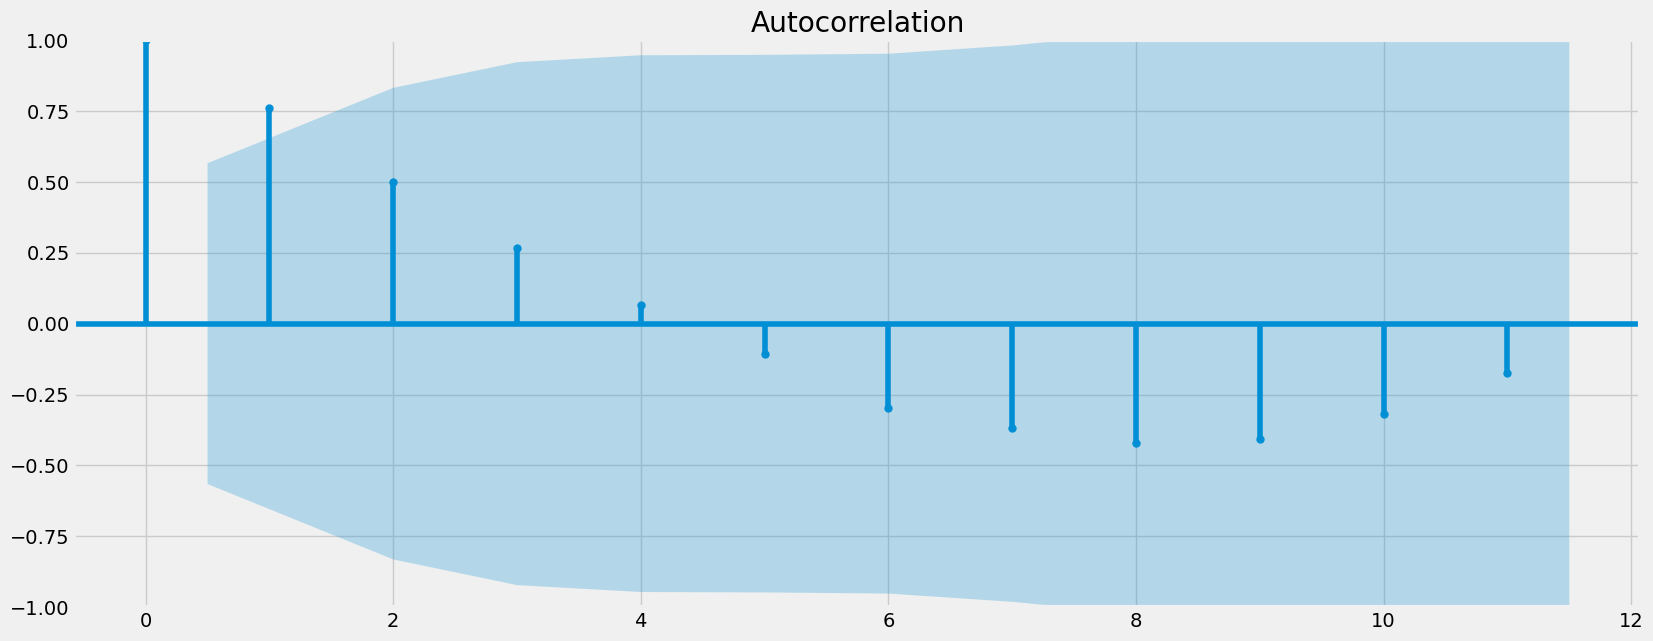

In [153]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, we import the autocorrelation and partial correlation plots

plot_acf(df_1)
plt.show()

Observations: The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means we have lags that are significantly correlated with each other. And when we have many lags beyond this interval, we can deduce that our data is non-stationary. In the case above, we have only 2 out of 10 lags that go above the blue edge of the confidence interval in the autocorrelation plot, it suggests that there might be some correlation between those particular lags. 
==> We will conduct a round of differencing on it.

## 5. Stationarizing the NY grad Rate 2011-2022 Data

In [155]:
df_1_diff = df_1 - df_1.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [156]:
df_1_diff.dropna(inplace = True) # Here, we remove the missing values that came about as a result of the differencing. 
# we need to remove these or you won't be able to run the Dickey-Fuller test.

In [157]:
df_1_diff.head()

Year,Grad Rate
2012,0.0
2013,0.0
2014,1.0
2015,1.0
2016,1.0


In [158]:
df_1_diff.columns

Index(['Grad Rate'], dtype='object', name='Year')

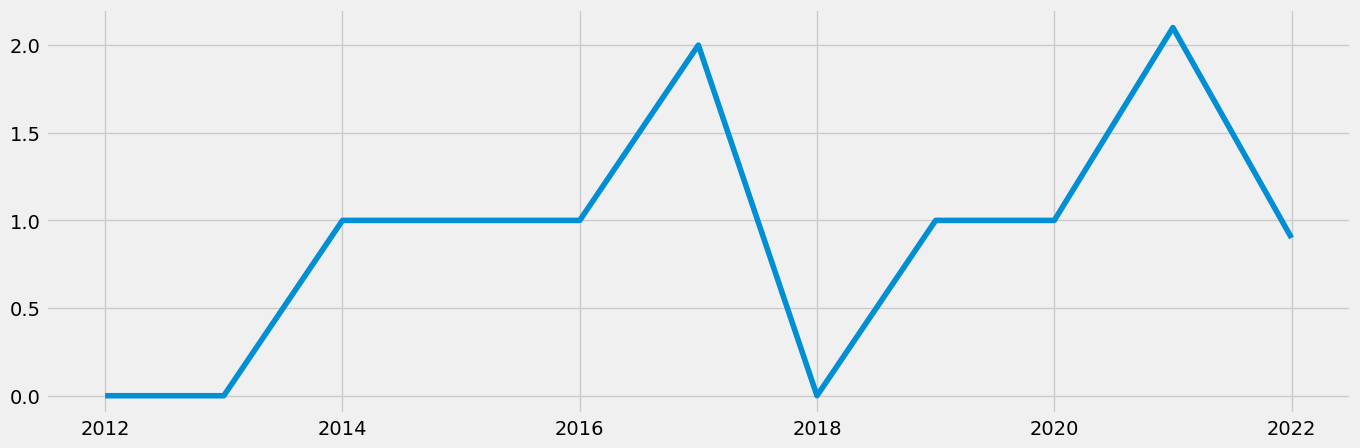

In [159]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_1_diff)

In [160]:
dickey_fuller(df_1_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.185974
p-value                         0.020811
Number of Lags Used             0.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


Observations: 

The p-value indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05, we have 0.02 ==> The null hypothesis is disproved. 

The absolute value of the test statistic (| -3.185974 |) is smaller than the absolute values of the critical values (-4.331573, -3.232950, -2.748700). Therefore, we fail to reject the null hypothesis, indicating that there is not enough evidence to conclude that the data is stationary. 

==> The data is stationary but a weak one.

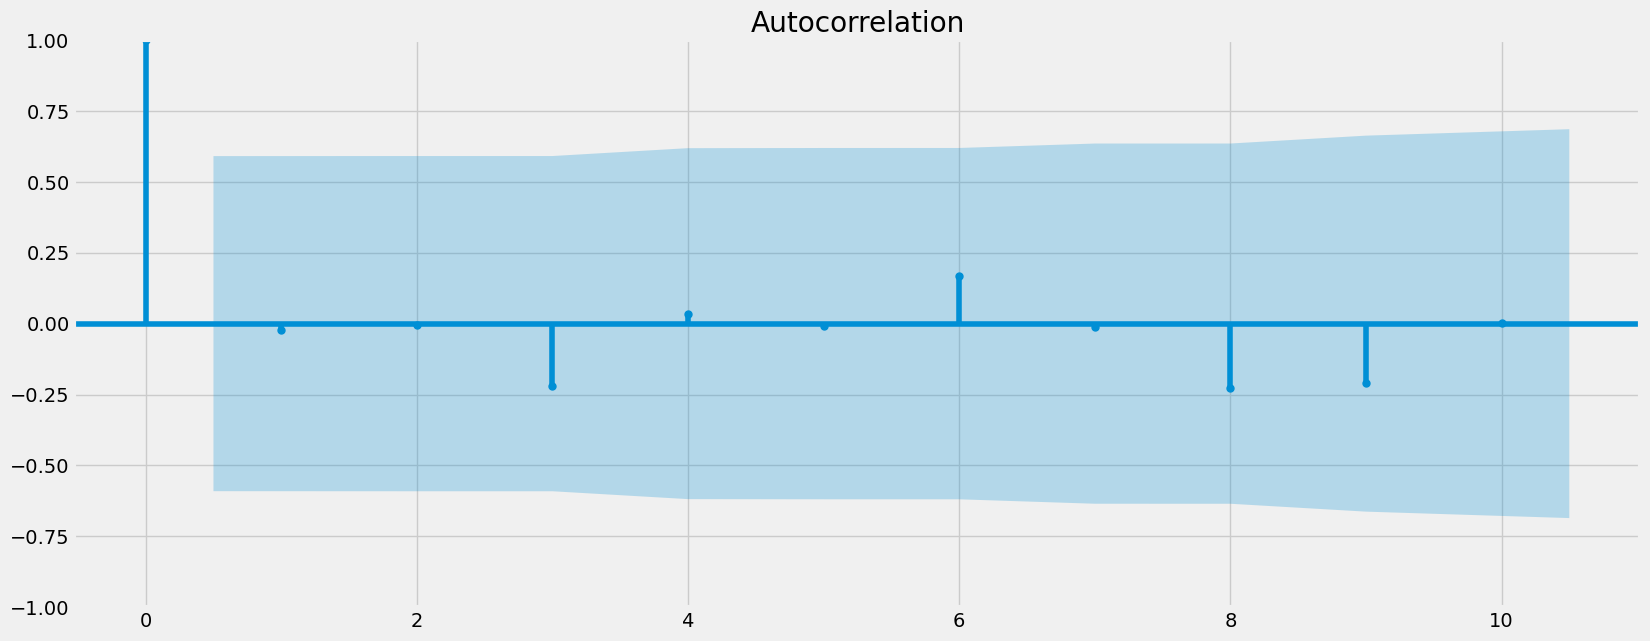

In [162]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, we import the autocorrelation and partial correlation plots

plot_acf(df_1_diff)
plt.show()

Observation: While the autocorrelation plot has improved ( from 2 lags above the confidence interval, now only 1 lag)  it’s still not perfect. This means that, it supports the Dickey-Fuller test saying that our data is weak stationary. 

Because of the unspoken rule of thumb that we need at least ten significant lags (or ten vertical lines above the confidence interval) for a second round of differencing to be necessary, we can stop here.